<a href="https://colab.research.google.com/github/trashchenkov/gigachat_tutorials/blob/main/%D0%93%D0%BE%D0%BB%D0%BE%D1%81%D0%BE%D0%B2%D0%BE%D0%B9_%D0%B1%D0%BE%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание бота на основе SaluteSpeech API и GigaChat API

В этом туториале нам предстоит несколько важных этапов:



1.   Знакомство с технологиями Speech2Text и Text2Speech
2.   Подключение и начало работы с SaluteSpeech API (сегодня рассмотрим только синхронный режим)
3.   Сравнение человеческой речи и машинной.  
4.   Соединение в единую программу SaluteSpeech API и GigaChat API (для последнего используем уже хорошо знакомый по прошлым туториалам GigaChain)
4.   Создание графического интерфейса для бота на основе Gradio

В результате этого туториала мы получим такое техническоее решение.



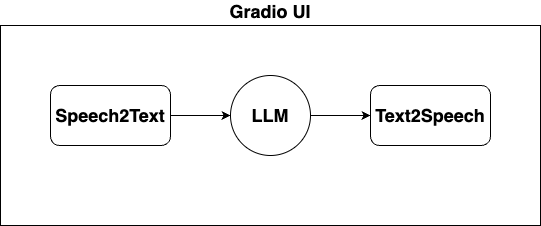

## Установка необходимых библиотек
Сегодня нам понадобятся:

- GigaChain и gigachain-community для работы с языковой моделью
- Gradio для графического интерфейса
- ffmpeg-python для работы со звуком в Colab

Полноценного официального SDK для работы с SaluteSpeech API на Python я не нашел. Есть [примеры кода](https://github.com/salute-developers/salute-speech/) для запуска из терминала. Еще попался вот такой [pet-проект](https://github.com/mmua/salute_speech). Поэтому мы будем просто писать код, используя возможности пакета `requests`.

In [28]:
!pip install -q gradio gigachain gigachain-community ffmpeg-python

## Знакомство с технологиями Speech2Text и Text2Speech
### Speech2Text

Вот пример того, как устроена Speech2Text Whisper, которую мы использовали в [туториале про RAG для видеороликов](https://youtu.be/slfC9um1qdk). Подобным же образом работает и модель от Сбера.

Рейтинг лучших Speech2Text моделей можно посмотреть [здесь](https://huggingface.co/spaces/hf-audio/open_asr_leaderboard).

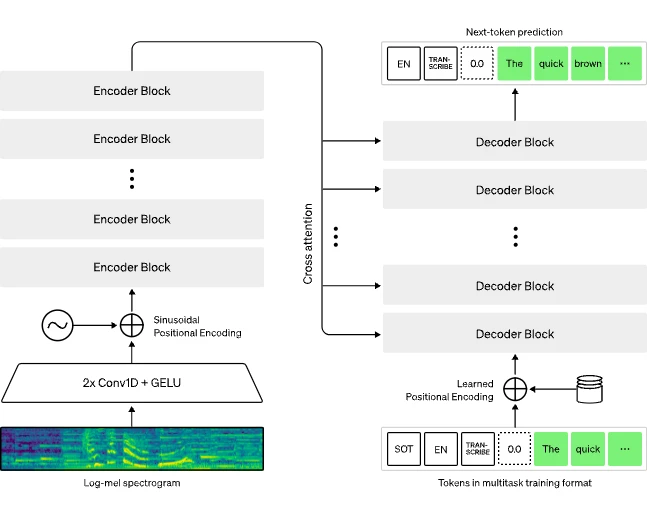

### Text2Speech
У Text2Speech большое многообразие архитектур моделей. В общем виде их можно представить в виде, показанном ниже. Рейтинг моделей для синтеза речи можно посмотреть [здесь](https://huggingface.co/spaces/TTS-AGI/TTS-Arena).


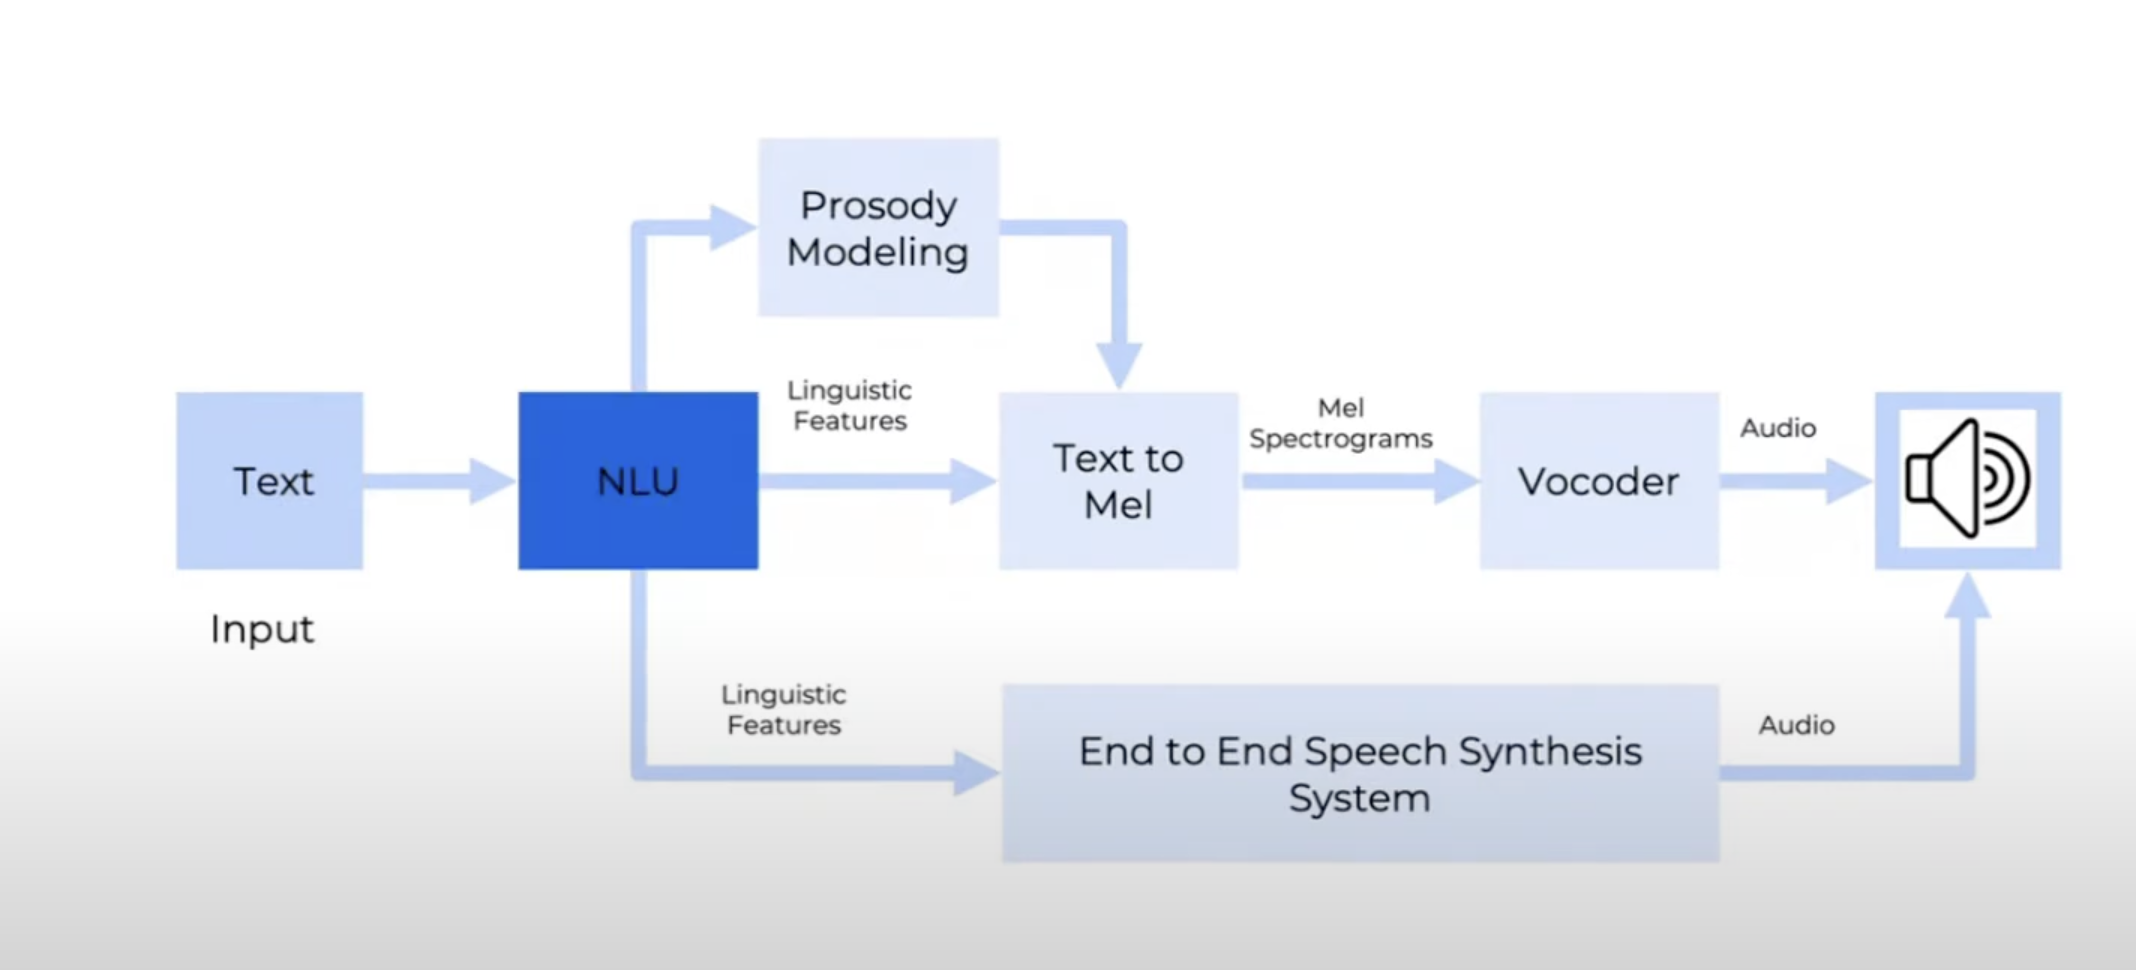

## Подключение и начало работы с SaluteSpeech API
Официальную документацию можно посмотреть [здесь](https://developers.sber.ru/docs/ru/salutespeech/overview).

### Получение авторизационных данных
Чтобы начать писать код на Python для SaluteSpeech API, нужны авторизационные данные из кабинета Studio.

1. Авторизуемся в Studio
2. Создаем проект SaluteSpeech
3. Зайдя в проект, получаем Secret и Авторизационные данные справа.
4. Сохраняем Авторизационные данные в надежном месте (я для этого использую раздел "Секреты" Google Colab).


### Получение токена доступа
Прежде чем начать распознавать или синтезировать речь через SaluteSpeech API нужно получить токен доступа. Для этого сделаем POST запрос, передав авторизационные данные, идентификатор UUID и масштаб, который показывает физическое лицо пользуется API или юридическое. При подключении отменяем проверку сертификатов SSL.



In [29]:
from google.colab import userdata
auth = userdata.get('SALUTE_SPEECH')

In [30]:
import requests
import uuid

def get_token(auth_token, scope='SALUTE_SPEECH_PERS'):
    """
      Выполняет POST-запрос к эндпоинту, который выдает токен.

      Параметры:
      - auth_token (str): токен авторизации, необходимый для запроса.
      - область (str): область действия запроса API. По умолчанию — «SALUTE_SPEECH_PERS».

      Возвращает:
      - ответ API, где токен и срок его "годности".
      """
    # Создадим идентификатор UUID (36 знаков)
    rq_uid = str(uuid.uuid4())

    # API URL
    url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

    # Заголовки
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'RqUID': rq_uid,
        'Authorization': f'Basic {auth_token}'
    }

    # Тело запроса
    payload = {
        'scope': scope
    }

    try:
        # Делаем POST запрос с отключенной SSL верификацией
        # (можно скачать сертификаты Минцифры, тогда отключать проверку не надо)
        response = requests.post(url, headers=headers, data=payload, verify=False)
        return response
    except requests.RequestException as e:
        print(f"Ошибка: {str(e)}")
        return None


Получим токен доступа.

In [31]:
response = get_token(auth)
if response != None:
    salute_token = response.json()['access_token']

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ngw.devices.sberbank.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### Распознавание речи
Согласно [документации](https://developers.sber.ru/docs/ru/salutespeech/recognition/recognition-sync) для распознавания речи в синхронном режиме нужно передать следующее:
- для заголовка запроса:
  - токен доступа;
  - указать формат распознаваемого файла (WAV, MP3, OGG, FLAC)
- для тела запроса:
  - язык;
  - частота дискретизации;
  - включить или нет фильтр от нецензурщины;
  - число каналов в аудио (мы будем работать с одноканальным аудио).

  Некоторые параметры имеют значения по умолчанию, мы их передавать не будем. В качестве файлов мы используем WAV.

  Ответ на запрос от API включает в себя список строк распознанной речи и список эмоций для строк распознанной речи.

  Вот так будет выглядеть функция, которая открывает на чтение WAV-файл и передает данные по API. В качестве результата функция извлекает текст распознанной речи.



In [32]:
def stt(file_path, token):
    # URL для распознавания речи
    url = "https://smartspeech.sber.ru/rest/v1/speech:recognize"

    # Заголовки запроса
    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "audio/x-pcm;bit=16;rate=16000"
    }



    # Открытие аудио файла в бинарном режиме
    with open(file_path, "rb") as audio_file:
        audio_data = audio_file.read()

    # Отправка POST запроса
    response = requests.post(url, headers=headers, data=audio_data, verify=False)

    # Обработка ответа
    if response.status_code == 200:
        result = response.json()
        print("Весь ответ API:", result)
        return result["result"]
    else:
        print("Ошибка:", response.status_code, response.text)
        return response.text

Для запуска функции `stt()` нужны файлы с речью. Давайте для этого реализуем запись речи с микрофона.

Запись с микрофона не представляла бы сложностей, если бы код запускался локально. Тогда мы бы воспользовались библиотекой `pyaudio`. Но поскольку это блокнот Google Colab, код выполняется на виртуальной машине в облаке, а значит у Python кода нет доступа к микрофону. Чтобы получить доступ к микрофону придется сделать вставку на JS прямо в коде на Python. JS выполняется в браузере, поэтому через браузер сможет подключиться к микрофону.

Код не мой, найден в свое время где-то на просторах Stack Overflow.

In [33]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Начать запись");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Остановить запись";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Идет сохранение"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

Вызовем функцию для записи. Результат можно будет прослушать.

In [34]:
audio, sr = get_audio()


Сохраним аудио в WAV-файл.

In [35]:
import scipy
scipy.io.wavfile.write('recording.wav', sr, audio)

Теперь можно вызвать функцию распознавания.

In [36]:
rec_speech = stt('recording.wav', salute_token)
print(rec_speech)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'smartspeech.sber.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Весь ответ API: {'result': ['Запись пошла, искусственный интеллект это уже реальность для нас с вами.'], 'emotions': [{'negative': 0.001574021, 'neutral': 0.99725646, 'positive': 0.001169611}], 'status': 200}
['Запись пошла, искусственный интеллект это уже реальность для нас с вами.']


### Синтез речи
Согласно [документации](https://developers.sber.ru/docs/ru/salutespeech/synthesis/synthesis-http) для синтеза речи в синхронном режиме нужно передать следующее:
- для заголовка:
 - токен доступа;
 - формат данных в запросе (`application/text` или `application/ssml`);
- для тела запроса:
  - формат получаемого аудио;
  - голос и частота дискретизации (выбираем из доступных в документации).


Сделаем функцию, которая отправляет запрос на синтез и сохраняет ответ в виде файла.


In [37]:
def synthesize_speech(text, token, format='wav16', voice='Bys_24000'):
    url = "https://smartspeech.sber.ru/rest/v1/text:synthesize"
    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/text"
    }
    params = {
        "format": format,
        "voice": voice
    }
    response = requests.post(url, headers=headers, params=params, data=text.encode(), verify=False)

    if response.status_code == 200:
        # Сохранение синтезированного аудио в файл
        with open('output.wav', 'wb') as f:
            f.write(response.content)
        print("Аудио успешно синтезировано и сохранено как 'output.wav'")

In [38]:
synthesize_speech(rec_speech[0], salute_token)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'smartspeech.sber.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Аудио успешно синтезировано и сохранено как 'output.wav'


Воспроизведем полученный файл.

In [39]:
audio_file = 'output.wav'
Audio(audio_file)

## Сравнение человеческой речи и машинной

Давайте взглянем на мел-спектрограммы двух наших аудио-файлов.

Мел-спектрограммы активно используются в ИИ для работы с речью. Они представляют собой визуализацию звука, где по оси X откладывается время, по оси Y - частота, а цветом задаются децибелы (мощность сигнала).

Для создания спектрограмм используется библиотека `librosa`

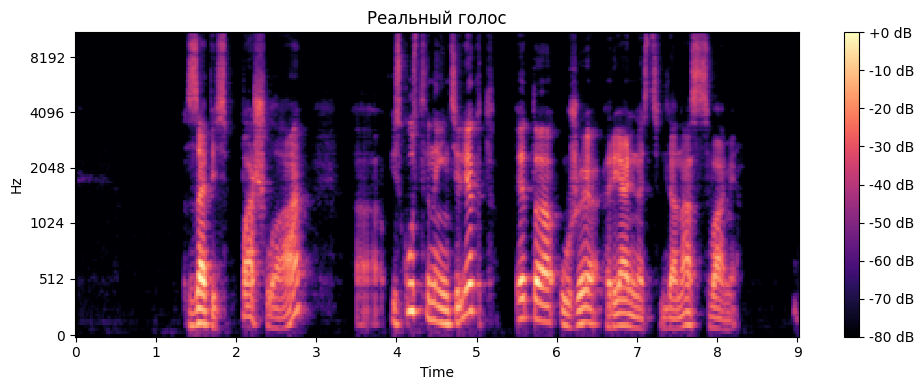

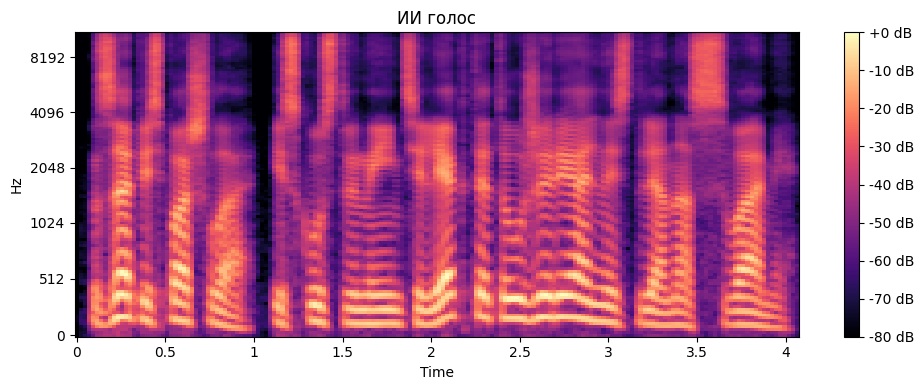

In [40]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Предполагаем, что у вас есть файл 'recording.wav'
file_path = 'recording.wav'

# Загрузка аудио с помощью librosa
audio, sr = librosa.load(file_path, sr=24000)

# Визуализация спектрограммы
plt.figure(figsize=(10, 4))
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Реальный голос')
plt.tight_layout()

# Загрузка другого аудио
audio, sr = librosa.load('output.wav', sr=24000)

plt.figure(figsize=(10, 4))
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('ИИ голос')
plt.tight_layout()

## Соединение в единую программу SaluteSpeech API и GigaChat API

Сделаем так, чтобы распознанная речь в виде текста передавалась языковой модели, а ответ модели отправлялся на синтез речи.

Для работы с языковой моделью используем класс `GigaChat` для взаимодействия с GigaChat API. Классы `ConversationChain` и `ConversationBufferMemory` задействуем, чтобы сделать диалоговую систему с памятью контекста разговора.

In [41]:
from google.colab import userdata
auth_giga = userdata.get('SBER_AUTH1')

In [42]:
from langchain.chat_models.gigachat import GigaChat
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

llm = GigaChat(credentials=auth_giga, verify_ssl_certs=False)
conversation = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationBufferMemory()
)

Соединим вместе речевые и текстовые составляющие.


In [45]:
audio, sr = get_audio()
scipy.io.wavfile.write('recording.wav', sr, audio)
rec_speech = stt('recording.wav', salute_token)
answer = conversation.predict(input=rec_speech[0])
audio_answer = synthesize_speech(answer, salute_token)
Audio('output.wav')



/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'smartspeech.sber.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Весь ответ API: {'result': ['Да, расскажи, как работают современные нейросети, которые преобразуют текст в похожую на человеческую речь.'], 'emotions': [{'negative': 0.002158124, 'neutral': 0.9977956, 'positive': 4.6237517e-05}], 'status': 200}


> Entering new ConversationChain chain...
Prompt after formatting:
Ниже приводится дружеский разговор между человеком и AI. AI разговорчив и предоставляет множество конкретных деталей из своего контекста. Если AI не знает ответа на вопрос, он честно говорит, что не знает.

Текущий разговор:
Human: Привет, как твои дела?
AI: Привет! У меня все хорошо, спасибо за интерес. Я постоянно работаю над улучшением своих навыков и знаний. А как у тебя дела?
Human: У меня тоже все хорошо, я тоже работаю над своими навыками. Вот сейчас, например, работаю над преобразованием текста в речь.
AI: Это очень полезный навык. Могу ли я чем-то помочь тебе с этим?
Human: Да, расскажи, как работают современные нейросети, которые преобразуют текст в похожую на человеч

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'smartspeech.sber.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Аудио успешно синтезировано и сохранено как 'output.wav'


Технически все работает неплохо, но интерфейс неудобен, поэтому обратимся к Gradio, которым уже пользовались в прошлых туториалах: [здесь](https://youtu.be/slfC9um1qdk) и [здесь](https://youtu.be/1P7ajSgpDcU).

## Создание графического интерфейса для бота на основе Gradio

У Gradio есть компонент для работы с [аудио](https://www.gradio.app/docs/gradio/audio). Он позволяет как записывать звук, так и воспроизводить. Поэтому в нашем интерфейсе будет два таких компонента, но с разными настройками.

Кроме того, нам понадобится компонент [Chatbot](https://www.gradio.app/docs/gradio/chatbot), чтобы показывать формирующийся диалог.

Вот как будет выглядеть конечная версия кода. В ней модифицирована функция `stt()`, а именно добавлен вызов функции `get_token()`. Благодаря этому токен доступа постоянно обновляется и не возникает проблем с работой речевых API.

In [ ]:
import gradio as gr
from dotenv import load_dotenv
import requests
import uuid
from langchain.chat_models.gigachat import GigaChat
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory



def get_token(auth_token, scope='SALUTE_SPEECH_PERS'):
    """
      Выполняет POST-запрос к эндпоинту, который выдает токен.

      Параметры:
      - auth_token (str): токен авторизации, необходимый для запроса.
      - область (str): область действия запроса API. По умолчанию — «SALUTE_SPEECH_PERS».

      Возвращает:
      - ответ API, где токен и срок его "годности".
      """
    # Создадим идентификатор UUID (36 знаков)
    rq_uid = str(uuid.uuid4())

    # API URL
    url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

    # Заголовки
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'RqUID': rq_uid,
        'Authorization': f'Basic {auth_token}'
    }

    # Тело запроса
    payload = {
        'scope': scope
    }

    try:
        # Делаем POST запрос с отключенной SSL верификацией
        # (можно скачать сертификаты Минцифры, тогда отключать проверку не надо)
        response = requests.post(url, headers=headers, data=payload, verify=False)
        return response.json()['access_token']
    except requests.RequestException as e:
        print(f"Ошибка: {str(e)}")


def stt(file_path):
    # URL для распознавания речи
    url = "https://smartspeech.sber.ru/rest/v1/speech:recognize"
    token = get_token(auth_token=auth)
    # Заголовки запроса
    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "audio/x-pcm;bit=16;rate=16000"
    }

    # Открытие аудио файла в бинарном режиме
    with open(file_path, "rb") as audio_file:
        audio_data = audio_file.read()

    # Отправка POST запроса
    response = requests.post(url, headers=headers, data=audio_data, verify=False)

    # Обработка ответа
    if response.status_code == 200:
        result = response.json()
        print("Распознанный текст:", result["result"])
        return result["result"][0], token
    else:
        print("Ошибка:", response.status_code, response.text)
        return response.text


def synthesize_speech(text, token, format='wav16', voice='Bys_24000'):
    url = "https://smartspeech.sber.ru/rest/v1/text:synthesize"
    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/text"
    }
    params = {
        "format": format,
        "voice": voice
    }
    response = requests.post(url, headers=headers, params=params, data=text.encode(), verify=False)

    if response.status_code == 200:
        # Сохранение синтезированного аудио в файл
        with open('output.wav', 'wb') as f:
            f.write(response.content)
        print("Аудио успешно синтезировано и сохранено как 'output.wav'")
        return 'output.wav'
    else:
        print(f"Ошибка синтеза: {response.status_code} - {response.json()}")


def process_audio(audio, chat_history):
    print('In progress...')
    print(audio)
    text, token = stt(audio)
    print(text)
    answer = conversation.predict(input=text)
    audio_answer = synthesize_speech(answer, token)
    chat_history.append((text, answer))
    return audio_answer, chat_history



with gr.Blocks() as demo:
    gr.Markdown("## Чат-бот с голосовым вводом")
    with gr.Row():
        audio_input = gr.Audio(label="Запишите сообщение", format='wav', type='filepath', sources='microphone')
        with gr.Column():
            chat = gr.Chatbot(label='Диалог с ИИ')
            audio_output = gr.Audio(label='Воспроизведение ответов ИИ', sources=None, autoplay=True)
    audio_input.stop_recording(fn=process_audio, inputs=[audio_input, chat], outputs=[audio_output, chat])

chat_history_m = []

llm = GigaChat(credentials=auth_giga, verify_ssl_certs=False)
conversation = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationBufferMemory()
)

demo.launch(debug=True)
